In [1]:
import os
from tqdm import tqdm
import pickle
import random
from typing import List, Dict, Tuple
from anndata import AnnData

import pandas as pd
import numpy as np
import math
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

import metaspace
import linex2metaspace as lx2m
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from statannotations.Annotator import Annotator
import networkx as nx

Package 'lynx' (LipidLynxX) not available. Lipid name conversions will not be possible.


In [2]:
import utils
from config import store_dir, data_dir, date_key, enrichment_dir
%load_ext autoreload
%autoreload 2

# Load data

In [3]:
pos_lip_top_datasets = pickle.load(open(os.path.join(store_dir, 'pos_lip_top_datasets_list.pickle'), "rb" ))

# Helper functions

In [4]:
def load_tissue_datasets(ds_list: pd.Series, include_offsample: bool=False, fdr: float=0.1, path=os.path.join(store_dir, 'all_ionimages/')) -> Dict[str, AnnData]:
    out_ads = {}
    for ds in ds_list:
        out_ads[ds] = pickle.load(open(os.path.join(path, f'{ds}.pickle'), "rb" ))
        if not include_offsample:
            out_ads[ds] = out_ads[ds][:, out_ads[ds].var['offSample'] == False]
        out_ads[ds] = out_ads[ds][:, out_ads[ds].var['fdr'] <= fdr]
        if out_ads[ds].shape[1] < 2:
            del out_ads[ds]
    return out_ads

def load_alltissue_datasets(tissue_ds_dict: Dict[str, pd.Series], include_offsample: bool=False, 
                            fdr: float=0.1, path=os.path.join(store_dir, 'all_ionimages/')) -> Dict[str, Dict[str, AnnData]]:
    out_dict = {}
    for k, v in tissue_ds_dict.items():
        out_dict[k] = load_tissue_datasets(v.index, include_offsample=include_offsample, fdr=fdr, path=path)
    
    return out_dict

def compute_colocs(ads: Dict[str, AnnData]) -> Tuple[Dict[str, pd.DataFrame], Dict[str, List]]:
    
    molecule_names = {}
    coloc_dict = {}

    for dsid, adat in ads.items():

        unique_labels = np.unique(adat.var.formula)
        sums = {}

        # Iterate over the unique labels
        for label in unique_labels:
            # Get the indices of rows with the current label
            indices = np.where(adat.var.formula == label)[0]
            # Sum up the corresponding rows and store the result
            if len(indices)>1:
                sums[label] = np.sum(adat.X[:, indices], axis=1)
            else:
                sums[label] = adat.X[:, indices[0]]

            molecule_names[label] = adat.var[adat.var['formula']==label]['moleculeNames'][0]

        tmp_array = np.stack(list(sums.values()))
        tmp_molecules = np.array(list(sums.keys()))
        tmp_ymax = adat.obs['y'].max()+1

        # Coloc preprocessing:
        conv_data = utils.coloc_preprocessing_array(tmp_array.transpose(), tmp_ymax)

        coloc = pairwise_kernels(conv_data, metric='cosine')

        coloc_df = pd.DataFrame(coloc, columns=tmp_molecules, index=tmp_molecules)

        coloc_dict[dsid] = coloc_df
        
    return coloc_dict, molecule_names

def list_same_colocs(coloc_dict: Dict[str, pd.DataFrame]) -> Dict[Tuple[str, str], List[float]]:
    ii_dict = {}
    for ds in coloc_dict.values():
        idx = list(ds.index)
        for ion1 in range(len(idx)):
            for ion2 in range(ion1, len(idx)):
                if idx[ion1] != idx[ion2]:
                    tmp = tuple(sorted([idx[ion1], idx[ion2]]))
                    if tmp in ii_dict.keys():
                        ii_dict[tmp].append(ds.loc[idx[ion1], idx[ion2]])
                    else:
                        ii_dict[tmp] = [ds.loc[idx[ion1], idx[ion2]]]
                        
    return ii_dict


def coloc_measures(ii_dict: Dict[Tuple[str, str], List[float]],
                   num_datasets: int,
                   min_datasets: int=10,
                  ):
    mean_l = []
    var_l = []
    cv_l = []
    cooc_l = []
    ion_paris = []

    for ii, x in ii_dict.items():
        if len(x) >= min_datasets:
            if not all(np.array(x)==0):
                mean_l.append(np.mean(x))
                var_l.append(np.var(x))
                cv_l.append(np.std(x)/np.mean(x))
                cooc_l.append(len(x)/num_datasets)
                ion_paris.append(ii)
    
    return pd.DataFrame({'mean': mean_l, 'variance': var_l, 'cv': cv_l, 'coocurrence': cooc_l, 'ion_pairs': ion_paris})

def compute_lx_nets(coloc_dict: Dict[str, pd.DataFrame], molecule_names: Dict[str, List], ref_lip_dict, class_reacs, bootstraps: int=30):
    lx_nets = {}
    lx_annotations = {}

    for dsid in coloc_dict.keys():

        tmp_annotations = pd.Series({x: molecule_names[x] for x in coloc_dict[dsid].columns})

        parsed_lipids = lx2m.parse_annotation_series(tmp_annotations, 
                                                     ref_lip_dict, 
                                                     verbose=False) # True if you want to see all lipids that were not parsed

        keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
        parsed_annotations = pd.DataFrame({'molecule_names': tmp_annotations, 'parsed_lipids': parsed_lipids})
        parsed_annotations = parsed_annotations.loc[keep_annotations,:]


        net = lx2m.bootstrap_networks(lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                                      parsed_annotations['parsed_lipids'], 
                                      n=bootstraps, 
                                      lx2_class_reacs=class_reacs, 
                                      lx2_reference_lipids=lx2m.get_lx2_ref_lips(), 
                                      return_composed=True, print_iterations=False)


        ion_net = lx2m.ion_weight_graph(net, 
                                        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                                        bootstraps=bootstraps, 
                                        parsed_lipids=parsed_annotations['parsed_lipids'])

        lx_nets[dsid] = ion_net
        lx_annotations[dsid] = parsed_annotations
        
    return lx_nets, lx_annotations

def tissue_lx_nets(tissue_colocs: Dict[str, pd.DataFrame], ref_lip_dict, class_reacs, bootstraps: int=30):
    
    out_dict = {}
    for tissue, colocs in tissue_colocs.items():
        print(tissue)
        out_dict[tissue] = {}
        nets, annotations = compute_lx_nets(colocs['coloc_dict'], molecule_names=colocs['molecule_names'], 
                                            ref_lip_dict=ref_lip_dict, class_reacs=class_reacs, bootstraps=bootstraps)
        out_dict[tissue]['nets'] = nets
        out_dict[tissue]['parsed_annotations'] = annotations
    
    return out_dict

def catch_sp(g, source, target):
    try:
        return nx.shortest_path_length(g, source, target)
    except nx.NetworkXNoPath:
        return np.inf
    
def all_tissue_colocs(tissue_adatas: Dict[str, Dict[str, AnnData]], min_dataset_fraction: int=0.3):
    
    out_dict = {}
    for tissue, adatas in tissue_adatas.items():
        print(tissue)
        out_dict[tissue] = {}
        
        coloc_dict, molecule_names = compute_colocs(adatas)
        ii_dict = list_same_colocs(coloc_dict)
        
        tmp = int(len(adatas)*min_dataset_fraction)
        
        min_datasets = tmp if tmp>2 else 2
        
        c_measures = coloc_measures(ii_dict, min_datasets=min_datasets, num_datasets=len(adatas))
        
        out_dict[tissue]['coloc_dict'] = coloc_dict
        out_dict[tissue]['molecule_names'] = molecule_names
        out_dict[tissue]['ii_dict'] = ii_dict
        out_dict[tissue]['c_measures'] = c_measures
        out_dict[tissue]['c_measures_min_datasets'] = min_datasets
    return out_dict

def flatten(l):
    return [item for subl in l for item in subl]

# Load datasets

In [5]:
tissue_ads = load_alltissue_datasets(pos_lip_top_datasets)

In [6]:
# exclude datasets

del tissue_ads['Brain']['2022-08-24_00h20m06s']
del tissue_ads['Brain']['2022-08-23_23h48m59s']
del tissue_ads['Buccal mucosa']

In [7]:
int(15*0.35)

5

# Colocalization analysis

In [8]:
tissue_colocs = all_tissue_colocs(tissue_adatas=tissue_ads, min_dataset_fraction=0.2)

Kidney
Brain
Lung
Ovary
Epididymis
Liver


## Coloc robustness

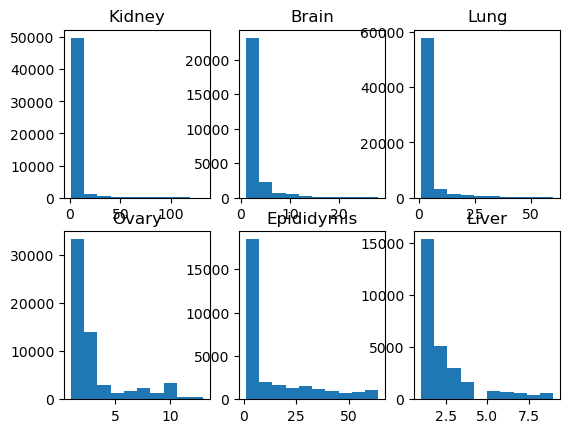

In [9]:
rows, columns = utils.compute_subplot_arrangement(len(tissue_colocs))
fig, axs = plt.subplots(rows, columns)
axs = flatten(axs)

counter = 0
for tissue in tissue_colocs.keys():
    axs[counter].hist([len(x) for x in tissue_colocs[tissue]['ii_dict'].values()])
    axs[counter].set_title(tissue)
    counter += 1
plt.show()

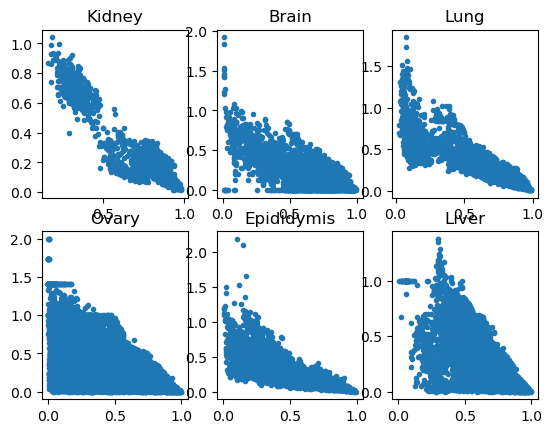

In [36]:
rows, columns = utils.compute_subplot_arrangement(len(tissue_colocs))
fig, axs = plt.subplots(rows, columns)
axs = flatten(axs)

counter = 0
for tissue in tissue_colocs.keys():
    axs[counter].plot(tissue_colocs[tissue]['c_measures']['mean'], tissue_colocs[tissue]['c_measures']['cv'], '.')
    axs[counter].set_title(tissue)
    counter += 1
plt.show()

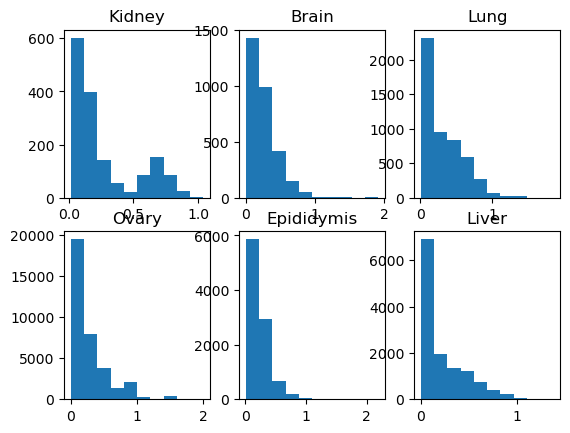

In [37]:
rows, columns = utils.compute_subplot_arrangement(len(tissue_colocs))
fig, axs = plt.subplots(rows, columns)
axs = flatten(axs)

counter = 0
for tissue in tissue_colocs.keys():
    axs[counter].hist(tissue_colocs[tissue]['c_measures']['cv'])
    axs[counter].set_title(tissue)
    counter += 1
plt.show()

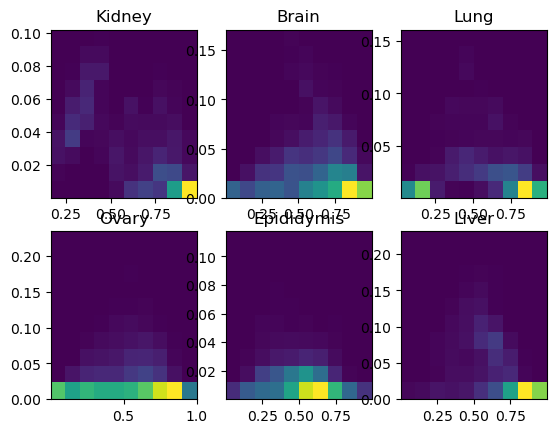

In [11]:
rows, columns = utils.compute_subplot_arrangement(len(tissue_colocs))
fig, axs = plt.subplots(rows, columns)
axs = flatten(axs)

counter = 0
for tissue in tissue_colocs.keys():
    axs[counter].hist2d(tissue_colocs[tissue]['c_measures']['mean'], tissue_colocs[tissue]['c_measures']['variance'])
    axs[counter].set_title(tissue)
    counter += 1
plt.show()

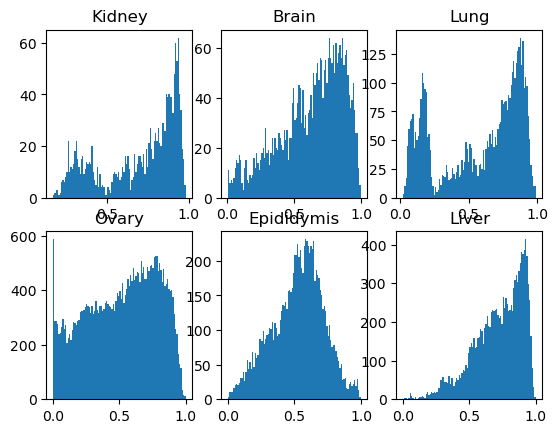

In [12]:
rows, columns = utils.compute_subplot_arrangement(len(tissue_colocs))
fig, axs = plt.subplots(rows, columns)
axs = flatten(axs)

counter = 0
for tissue in tissue_colocs.keys():
    axs[counter].hist(tissue_colocs[tissue]['c_measures']['mean'], bins=100)
    axs[counter].set_title(tissue)
    counter += 1
plt.show()

## Coloc vs. co-occurrence

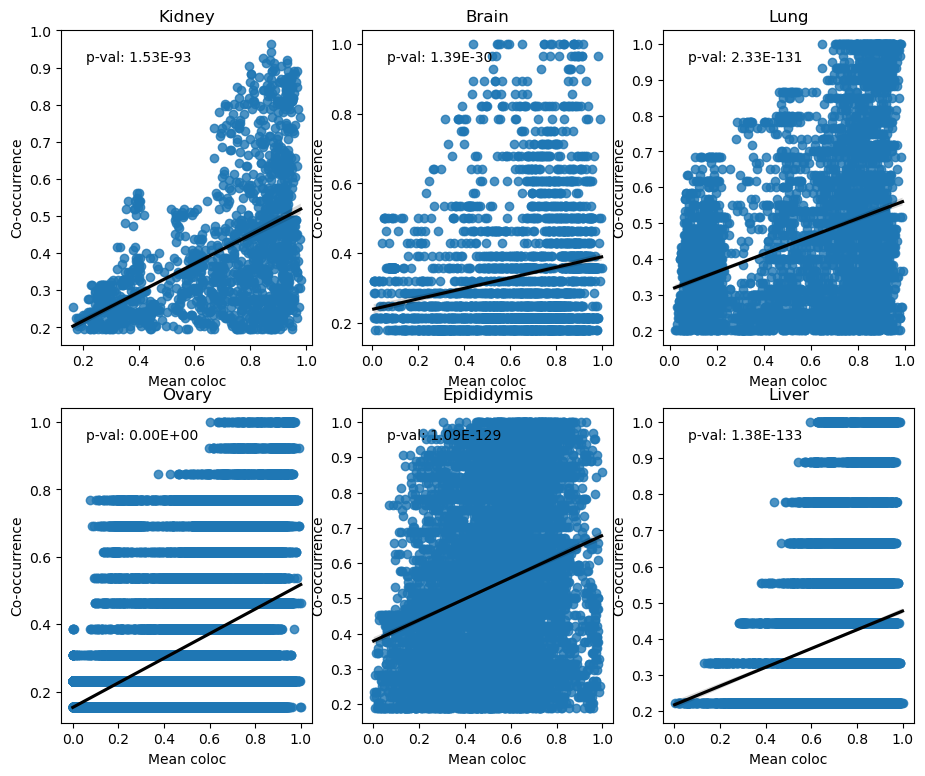

In [13]:
rows, columns = utils.compute_subplot_arrangement(len(tissue_colocs))
fig, axs = plt.subplots(rows, columns, figsize=(11, 9))
axs = flatten(axs)

counter = 0
for tissue in tissue_colocs.keys():
    
    sns.regplot(x="mean", y="coocurrence", data=tissue_colocs[tissue]['c_measures'], ax=axs[counter], line_kws={"color": "black"})
    #ax2.hist2d(mean_l, cooc_l)
    axs[counter].set_xlabel('Mean coloc')
    axs[counter].set_ylabel('Co-occurrence')
    pval = stats.linregress(tissue_colocs[tissue]['c_measures']['mean'], tissue_colocs[tissue]['c_measures']['coocurrence']).pvalue
    axs[counter].text(0.1, 0.9, 'p-val: {:.2E}'.format(pval), transform=axs[counter].transAxes)
    axs[counter].set_title(tissue)
    counter += 1
plt.show()

## Inter-tissue coloc

(array([34064.,  7946.,  2750.,  1090.,   561.,   393.]),
 array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
        5.16666667, 6.        ]),
 <BarContainer object of 6 artists>)

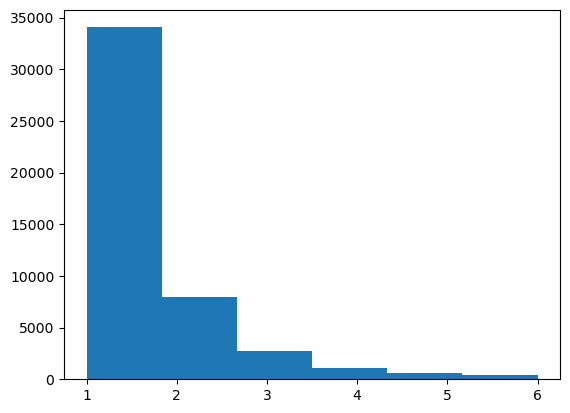

In [66]:
c_concat = pd.concat([v['c_measures'].assign(tissue=k) for k, v in tissue_colocs.items()])
c_concat_mean = c_concat.drop(columns=['tissue']).groupby(['ion_pairs']).agg(['mean', 'count'])

df = pd.DataFrame({'mean': c_concat_mean[('mean', 'mean')], 
                   'variance': c_concat_mean[('variance', 'mean')], 
                   'cv': c_concat_mean[('cv', 'mean')], 
                   'coocurrence': c_concat_mean[('coocurrence', 'mean')],
                   'counts': c_concat_mean[('mean', 'count')]}
                 )
df['In all 6 datasets'] = df['counts']==6

plt.hist(c_concat_mean[('mean', 'count')], bins=6)

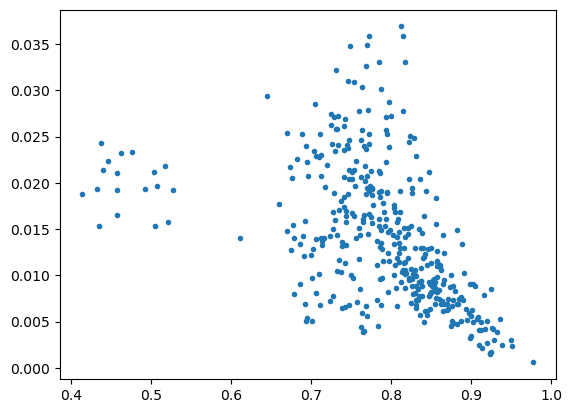

In [67]:
tmp = df[df['counts'] >=6]
plt.plot(tmp['mean'], tmp['variance'], '.')

<AxesSubplot: xlabel='cv', ylabel='Density'>

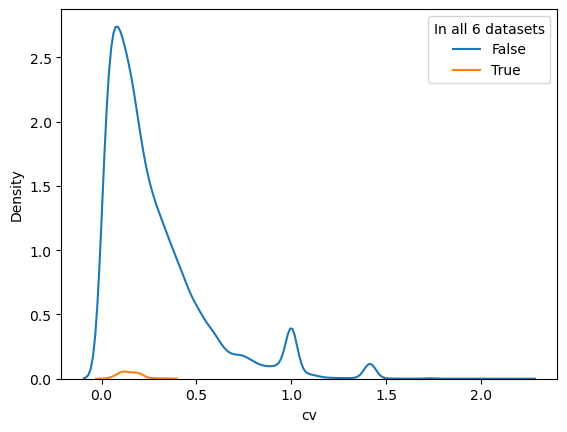

In [71]:
sns.kdeplot(data=df, x='cv', hue='In all 6 datasets')

<AxesSubplot: xlabel='cv', ylabel='Density'>

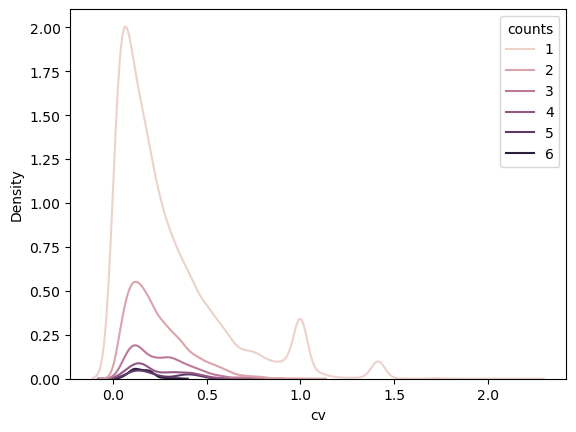

In [72]:
sns.kdeplot(data=df, x='cv', hue='counts')

(array([10., 33., 88., 80., 73., 71., 20.,  7.,  5.,  6.]),
 array([0.02201826, 0.05441667, 0.08681508, 0.11921349, 0.15161189,
        0.18401031, 0.21640873, 0.24880713, 0.28120553, 0.31360397,
        0.34600237]),
 <BarContainer object of 10 artists>)

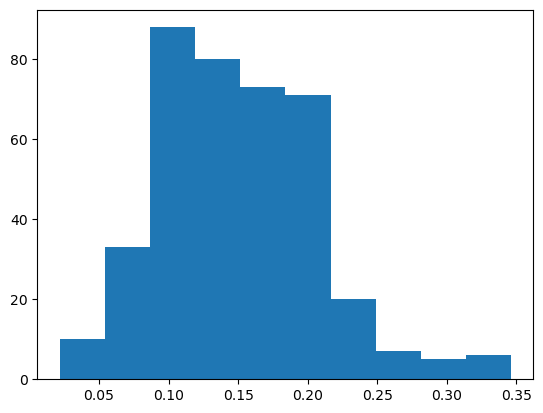

In [43]:
tmp = df[df['counts'] >=6]
plt.hist(tmp['cv'])

In [16]:
tmp

,mean,variance,cv,coocurrence,counts
ion_pairs,,,,,
"(C24H50NO7P, C26H52NO7P)",0.873023,0.008727,0.099575,0.569070,6
"(C24H50NO7P, C26H54NO7P)",0.893511,0.006363,0.077655,0.639783,6
"(C24H50NO7P, C28H33O14)",0.521078,0.015815,0.219602,0.505328,6
"(C24H50NO7P, C29H47NO4)",0.977326,0.000586,0.022018,0.851449,6
"(C24H50NO7P, C37H68O4)",0.745753,0.018798,0.173700,0.655089,6
...,...,...,...,...,...
"(C46H82NO8P, C47H95N2O6P)",0.738221,0.013207,0.209562,0.736301,6
"(C46H84NO8P, C46H86NO8P)",0.863880,0.007281,0.096668,0.613075,6
"(C46H84NO8P, C47H93N2O6P)",0.843914,0.019165,0.139975,0.878046,6


In [17]:
ref_lip_dict = lx2m.get_lx2_ref_lip_dict()
class_reacs = lx2m.get_organism_combined_class_reactions(ref_lip_dict=ref_lip_dict, organism='HSA')

In [18]:
selected_ions = list(set([item for tuple in tmp[tmp['mean']>0.6].index for item in tuple]))

molecule_names = {}
for val in tissue_colocs.values():
    for k, v in val['molecule_names'].items():
        molecule_names[k] = v

tmp_annotations = pd.Series({x: molecule_names[x] for x in selected_ions})


parsed_lipids = lx2m.parse_annotation_series(tmp_annotations, 
                                             ref_lip_dict, 
                                             verbose=False) # True if you want to see all lipids that were not parsed

keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
parsed_annotations = pd.DataFrame({'molecule_names': tmp_annotations, 'parsed_lipids': parsed_lipids})
parsed_annotations = parsed_annotations.loc[keep_annotations,:]

bootstraps = 30

net = lx2m.bootstrap_networks(
        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']),
        parsed_annotations['parsed_lipids'],
        n=bootstraps,
        lx2_class_reacs=class_reacs,
        lx2_reference_lipids=lx2m.get_lx2_ref_lips(),
        return_composed=True,
        print_iterations=False
    )


ion_net = lx2m.ion_weight_graph(net, 
                           lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                           bootstraps=bootstraps,
                           parsed_lipids=parsed_annotations['parsed_lipids'],
                           #feature_similarity=feature_sim
                          )
print(f'{len(ion_net.nodes)} of {len(selected_ions)} ions are part of the network')

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + (y_shift * np.random.choice([-1,1]))) for n,(x,y) in pos.items()}



28 of 30 ions are part of the network


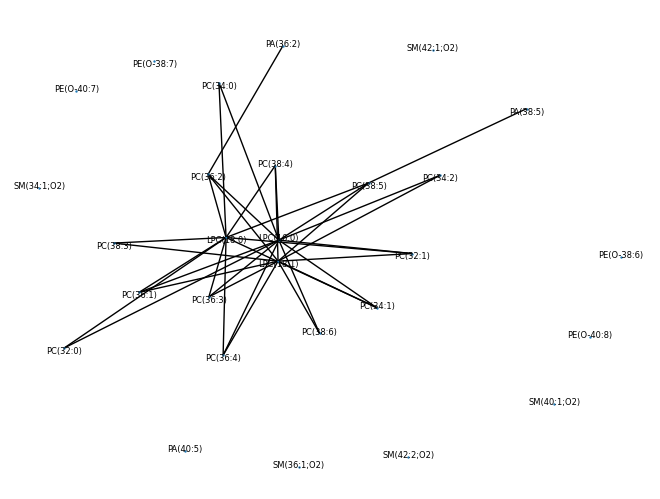

In [19]:
pos = nx.spring_layout(ion_net, k=.6)

nx.draw(ion_net, pos=pos, node_size=.5)
nx.draw_networkx_labels(ion_net, pos=nudge(pos, 0, 0.01),
                            labels={k: v['sum_species'].index[0] for k, v in dict(ion_net.nodes(data=True)).items()},
                            font_size=6)
plt.show()

In [20]:
len(selected_ions)

30

In [21]:
31*31

961

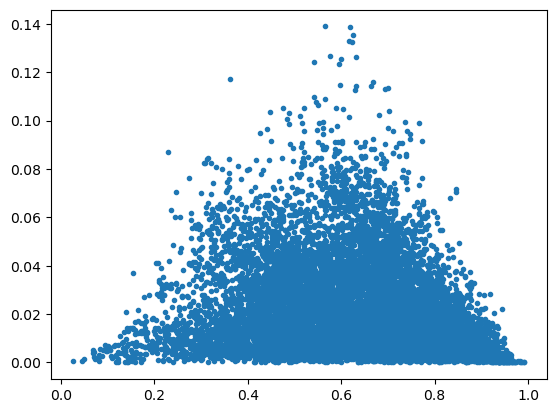

In [22]:
tmp = df[df['counts'] >=2]
plt.plot(tmp['mean'], tmp['variance'], '.')

## Module extraction

In [ ]:
c_measures = coloc_measures(ii_dict, min_datasets=10)
            
selected_ions = list(set([item for tup in c_measures['ion_pairs'] for item in tup]))

df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)

for x in range(c_measures.shape[0]):
    c_measures['ion_pairs'][x][0], c_measures['ion_pairs'][x][1]
    df.loc[c_measures['ion_pairs'][x][0], c_measures['ion_pairs'][x][1]] = c_measures['mean'][x]
    df.loc[c_measures['ion_pairs'][x][1], c_measures['ion_pairs'][x][0]] = c_measures['mean'][x]

a = sns.clustermap(df, cmap='GnBu')

hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clustering_labels = hierarchical_cluster.fit_predict(df)

clustering_labels

## Coloc vs. LINEX

In [23]:
# LINEX2 preprocessing
ref_lip_dict = lx2m.get_lx2_ref_lip_dict()
class_reacs = lx2m.get_organism_combined_class_reactions(ref_lip_dict=ref_lip_dict, organism='HSA')

In [24]:
tissue_lx = tissue_lx_nets(tissue_colocs, ref_lip_dict=ref_lip_dict, class_reacs=class_reacs, bootstraps=30)

Kidney
Brain
Lung
Ovary
Epididymis
Liver


Text(0.5, 1.0, 'Evaluation per dataset')

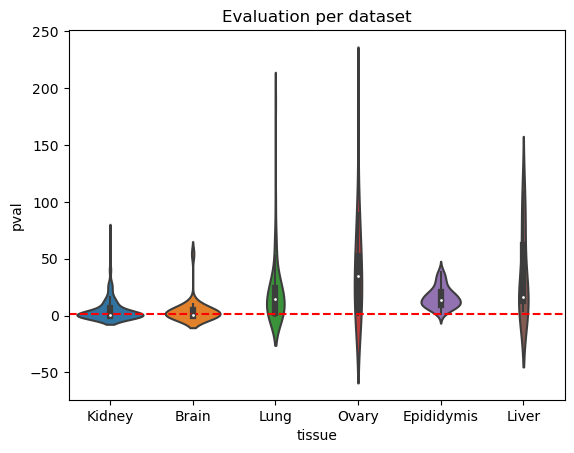

In [35]:
tissue_l = []
pval_l = []
for tissue in tissue_lx.keys():
    for dsid in tissue_lx[tissue]['nets'].keys():
        edge_cor = []
        nedge_cor = []
        eds_l = []
        nds_l = []

        max_hops = 2
        node_list = list(tissue_lx[tissue]['nets'][dsid].nodes)
        ig = tissue_lx[tissue]['nets'][dsid]
        ls = tissue_colocs[tissue]['coloc_dict'][dsid]
        for l1 in range(len(node_list)):
            for l2 in range(l1+1, len(node_list)):
                if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                    edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                    eds_l.append(dsid)
                else:
                    nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                    nds_l.append(dsid)
        if len(edge_cor)>0 and len(nedge_cor)>0:
            testres = scipy.stats.ranksums(edge_cor, nedge_cor, alternative='two-sided')
            tissue_l.append(tissue)
            pval_l.append(testres.pvalue)

            df = pd.DataFrame({'tissue': tissue_l, 'pval': pval_l})
df['pval']= statsmodels.stats.multitest.multipletests(df['pval'])[1]
df['pval'] = -np.log10(df['pval'])

ax = sns.violinplot(data=df, x='tissue', y='pval')
ax.axhline(y = -np.log10(0.05) , color = 'r', linestyle = '--')
ax.set_title('Evaluation per dataset')

### N co-occurence networks

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
69 of 99 ions are part of the network


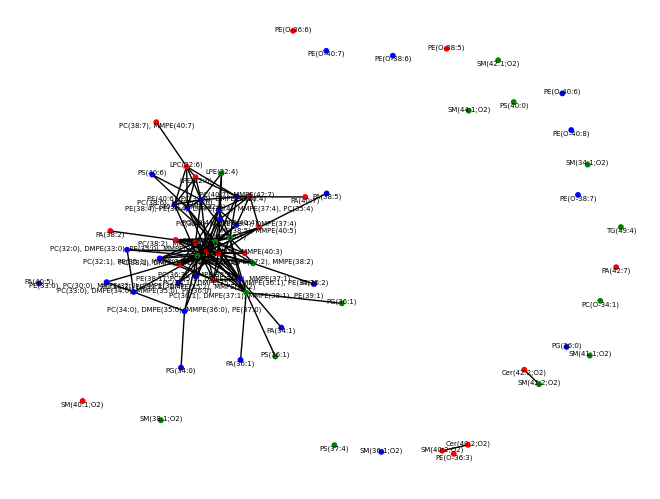

In [42]:
mean_d = {}
min_datasets = 5

counter = 0
for ii, x in ii_dict.items():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            if np.mean(x)>0.8 and np.var(x)<0.025:
                mean_d[ii] = np.mean(x)
            
selected_ions = list(set([item for tuple in mean_d for item in tuple]))


df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)
for k, v in mean_d.items():
    df.loc[k[0], k[1]] = v
    df.loc[k[1], k[0]] = v
    
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clustering_labels = hierarchical_cluster.fit_predict(df)

tmp_annotations = pd.Series({x: molecule_names[x] for x in selected_ions})

parsed_lipids = lx2m.parse_annotation_series(tmp_annotations, 
                                             ref_lip_dict, 
                                             verbose=False) # True if you want to see all lipids that were not parsed

keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
parsed_annotations = pd.DataFrame({'molecule_names': tmp_annotations, 'parsed_lipids': parsed_lipids})
parsed_annotations = parsed_annotations.loc[keep_annotations,:]


bootstraps = 30

net = lx2m.bootstrap_networks(
        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']),
        parsed_annotations['parsed_lipids'],
        n=bootstraps,
        lx2_class_reacs=class_reacs,
        lx2_reference_lipids=lx2m.get_lx2_ref_lips(),
        return_composed=True
    )

label_cols = {0: 'blue', 1: 'green', 2: 'red'}
label_dict = {k: v for k, v in zip(df.columns, clustering_labels)}


ion_net = lx2m.ion_weight_graph(net, 
                           lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                           bootstraps=bootstraps,
                           parsed_lipids=parsed_annotations['parsed_lipids'],
                           #feature_similarity=feature_sim
                          )
print(f'{len(ion_net.nodes)} of {len(selected_ions)} ions are part of the network')

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + (y_shift * np.random.choice([-1,1]))) for n,(x,y) in pos.items()}

pos = nx.spring_layout(ion_net, k=.2)

nx.draw(ion_net, node_color=[label_cols[label_dict[n]] for n in ion_net], node_size=10, pos=pos)
nx.draw_networkx_labels(ion_net, pos=nudge(pos, 0, 0.01),
                            labels={k: ", ".join(v['sum_species'].index) for k, v in dict(ion_net.nodes(data=True)).items()},
                            font_size=5)
plt.show()

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30
61 of 88 ions are part of the network


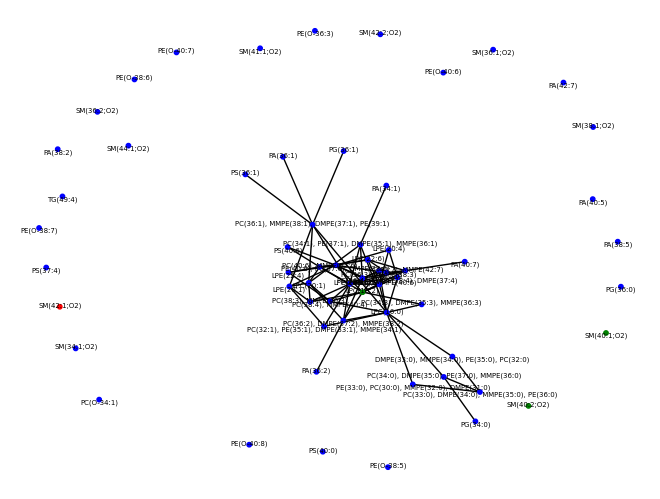

In [43]:
mean_d = {}
min_datasets = 5

counter = 0
for ii, x in ii_dict.items():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            if np.mean(x)<0.2 and np.var(x)<0.025:
                mean_d[ii] = np.mean(x)
            
selected_ions = list(set([item for tuple in mean_d for item in tuple]))


df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)
for k, v in mean_d.items():
    df.loc[k[0], k[1]] = v
    df.loc[k[1], k[0]] = v
    
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clustering_labels = hierarchical_cluster.fit_predict(df)

tmp_annotations = pd.Series({x: molecule_names[x] for x in selected_ions})

parsed_lipids = lx2m.parse_annotation_series(tmp_annotations, 
                                             ref_lip_dict, 
                                             verbose=False) # True if you want to see all lipids that were not parsed

keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
parsed_annotations = pd.DataFrame({'molecule_names': tmp_annotations, 'parsed_lipids': parsed_lipids})
parsed_annotations = parsed_annotations.loc[keep_annotations,:]


bootstraps = 30

net = lx2m.bootstrap_networks(
        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']),
        parsed_annotations['parsed_lipids'],
        n=bootstraps,
        lx2_class_reacs=class_reacs,
        lx2_reference_lipids=lx2m.get_lx2_ref_lips(),
        return_composed=True
    )

label_cols = {0: 'blue', 1: 'green', 2: 'red'}
label_dict = {k: v for k, v in zip(df.columns, clustering_labels)}


ion_net = lx2m.ion_weight_graph(net, 
                           lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                           bootstraps=bootstraps,
                           parsed_lipids=parsed_annotations['parsed_lipids'],
                           #feature_similarity=feature_sim
                          )
print(f'{len(ion_net.nodes)} of {len(selected_ions)} ions are part of the network')

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + (y_shift * np.random.choice([-1,1]))) for n,(x,y) in pos.items()}

pos = nx.spring_layout(ion_net, k=.2)

nx.draw(ion_net, node_color=[label_cols[label_dict[n]] for n in ion_net], node_size=10, pos=pos)
nx.draw_networkx_labels(ion_net, pos=nudge(pos, 0, 0.01),
                            labels={k: ", ".join(v['sum_species'].index) for k, v in dict(ion_net.nodes(data=True)).items()},
                            font_size=5)
plt.show()

# Testing

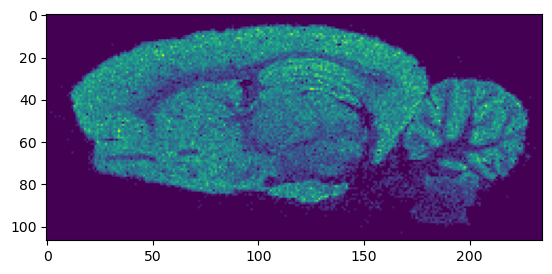

In [122]:
plt.imshow(tmp_array[237].reshape(adat.obs['y'].max()+1, -1))

In [ ]:
tmp = utils.coloc_preprocessing(brain_ads['2022-08-24_00h20m06s'])

In [84]:
adat.var

,formula,adduct,ionFormula,ion,mz,msm,rhoSpatial,rhoSpectral,moc,fdr,offSample,isotopeImages,colocCoeff,moleculeNames,moleculeIds,intensity
formula_adduct,,,,,,,,,,,,,,,,
C42H82NO8P+Na,C42H82NO8P,+Na,C42H82NO8PNa,C42H82NO8P+Na+,782.567090,0.942587,0.954109,0.981919,0.998802,0.033333,False,"[{'mz': 782.5670895885813, 'url': 'https://s3....",None,"[PC(14:0/20:1(11Z)), PC(14:1(9Z)/20:0), PC(16:...","[HMDB0007879, HMDB0007911, HMDB0007971, HMDB00...",172.843750
C42H82NO8P+K,C42H82NO8P,+K,C42H82NO8PK,C42H82NO8P+K+,798.541029,0.941862,0.982779,0.990116,0.998526,0.042857,False,"[{'mz': 798.5410294442759, 'url': 'https://s3....",None,"[PC(14:0/20:1(11Z)), PC(14:1(9Z)/20:0), PC(16:...","[HMDB0007879, HMDB0007911, HMDB0007971, HMDB00...",463.500000
C41H83N2O6P+K,C41H83N2O6P,+K,C41H83N2O6PK,C41H83N2O6P+K+,769.562095,0.922507,0.971342,0.975669,0.998405,0.042857,False,"[{'mz': 769.5620945400691, 'url': 'https://s3....",None,"[SM(d18:0/18:1(11Z)), SM(d18:0/18:1(9Z)), stea...","[HMDB0012088, HMDB0012089, HMDB0062559]",72.500000
C37H71O8P+K,C37H71O8P,+K,C37H71O8PK,C37H71O8P+K+,713.451867,0.907610,0.981760,0.980270,0.998728,0.042857,False,"[{'mz': 713.4518667581781, 'url': 'https://s3....",None,"[PA(16:0/18:1(11Z)), PA(16:0/18:1(9Z)), 9-Octa...","[HMDB0007858, HMDB0007859, HMDB0031130, HMDB01...",86.546875
C43H76NO7P+Na,C43H76NO7P,+Na,C43H76NO7PNa,C43H76NO7P+Na+,772.525223,0.905913,0.963896,0.977953,0.998662,0.059375,False,"[{'mz': 772.5252231593009, 'url': 'https://s3....",None,"[PE(20:4(5Z,8Z,11Z,14Z)/P-18:1(11Z)), PE(20:4(...","[HMDB0009413, HMDB0009414, HMDB0009446, HMDB00...",229.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C44H80O5+K,C44H80O5,+K,C44H80O5K,C44H80O5+K+,727.563789,0.667312,0.000292,0.826276,0.995035,0.199009,False,"[{'mz': 727.5637888022283, 'url': 'https://s3....",None,"[DG(22:1n9/0:0/18:2n6), DG(22:1(13Z)/19:2(10Z,...","[HMDB0056253, HMDB0116449]",0.748779
C48H84NO7P+K,C48H84NO7P,+K,C48H84NO7PK,C48H84NO7P+K+,856.561775,0.667181,0.009195,0.819448,0.991649,0.199009,False,"[{'mz': 856.5617748336741, 'url': 'https://s3....",None,"[PC(22:5(4Z,7Z,10Z,13Z,16Z)/P-18:1(11Z)), PC(2...","[HMDB0008687, HMDB0008688, HMDB0008720, HMDB00...",0.665894
C52H100NO8P+K,C52H100NO8P,+K,C52H100NO8PK,C52H100NO8P+K+,936.681905,0.666742,0.029271,0.806536,0.972113,0.199231,False,"[{'mz': 936.6819048453883, 'url': 'https://s3....",None,"[PC(20:1(11Z)/24:1(15Z)), PC(20:2(11Z,14Z)/24:...","[HMDB0008323, HMDB0008355, HMDB0008547, HMDB00...",0.865112


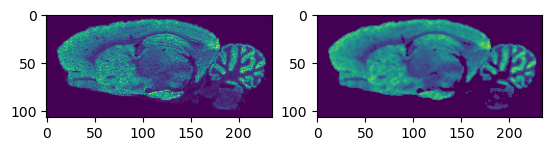

In [107]:
ds_id = '2022-07-19_19h29m24s'
conv_data = utils.coloc_preprocessing(brain_ads[ds_id])

fig, (ax1, ax2) = plt.subplots(ncols=2)

c = 2

ax1.imshow(brain_ads[ds_id].X.transpose().reshape((brain_ads[ds_id].X.shape[1], brain_ads[ds_id].obs['y'].max()+1, -1))[c])
ax2.imshow(conv_data.reshape((brain_ads[ds_id].X.shape[1], brain_ads[ds_id].obs['y'].max()+1, -1))[c])

# ASMS Poster plots

In [46]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

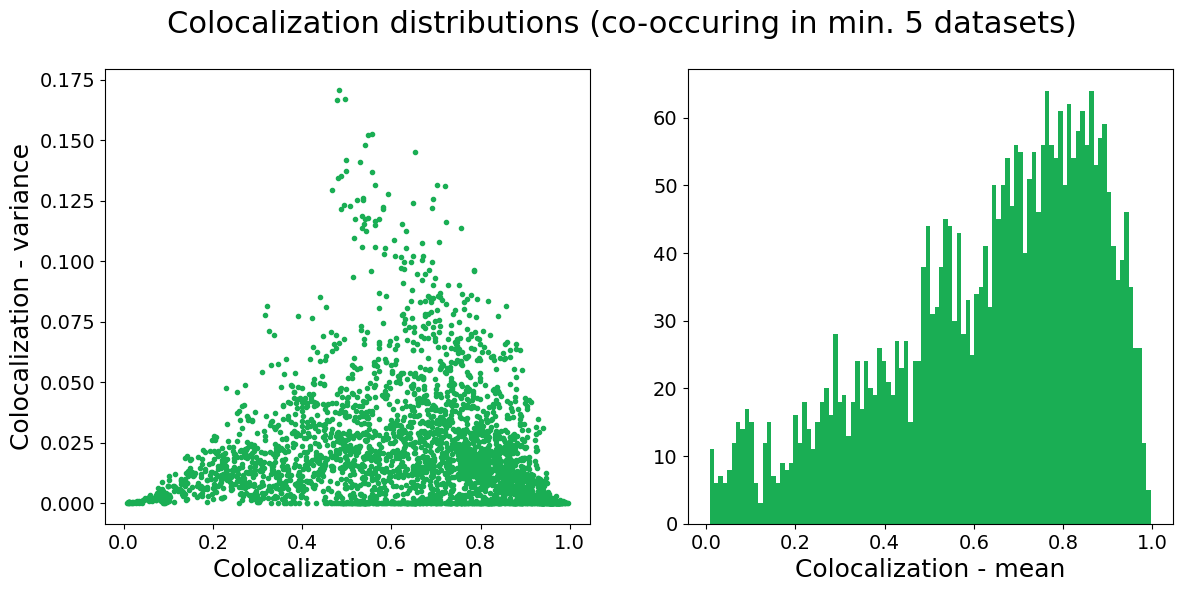

In [105]:
mean_l = []
var_l = []
cv_l = []
min_datasets = 5

for x in ii_dict.values():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_l.append(np.mean(x))
            var_l.append(np.var(x))
            cv_l.append(np.std(x)/np.mean(x))

cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35*cm, 15*cm))
plt.suptitle('Colocalization distributions (co-occuring in min. 5 datasets)')
            
ax1.plot(mean_l, var_l, '.', color='#1aae54')
ax1.set_xlabel('Colocalization - mean')
ax1.set_ylabel('Colocalization - variance')

ax2.hist(mean_l, bins=100, color='#1aae54')
ax2.set_xlabel('Colocalization - mean')

plt.savefig("plots/coloc_dist.png", dpi=400)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


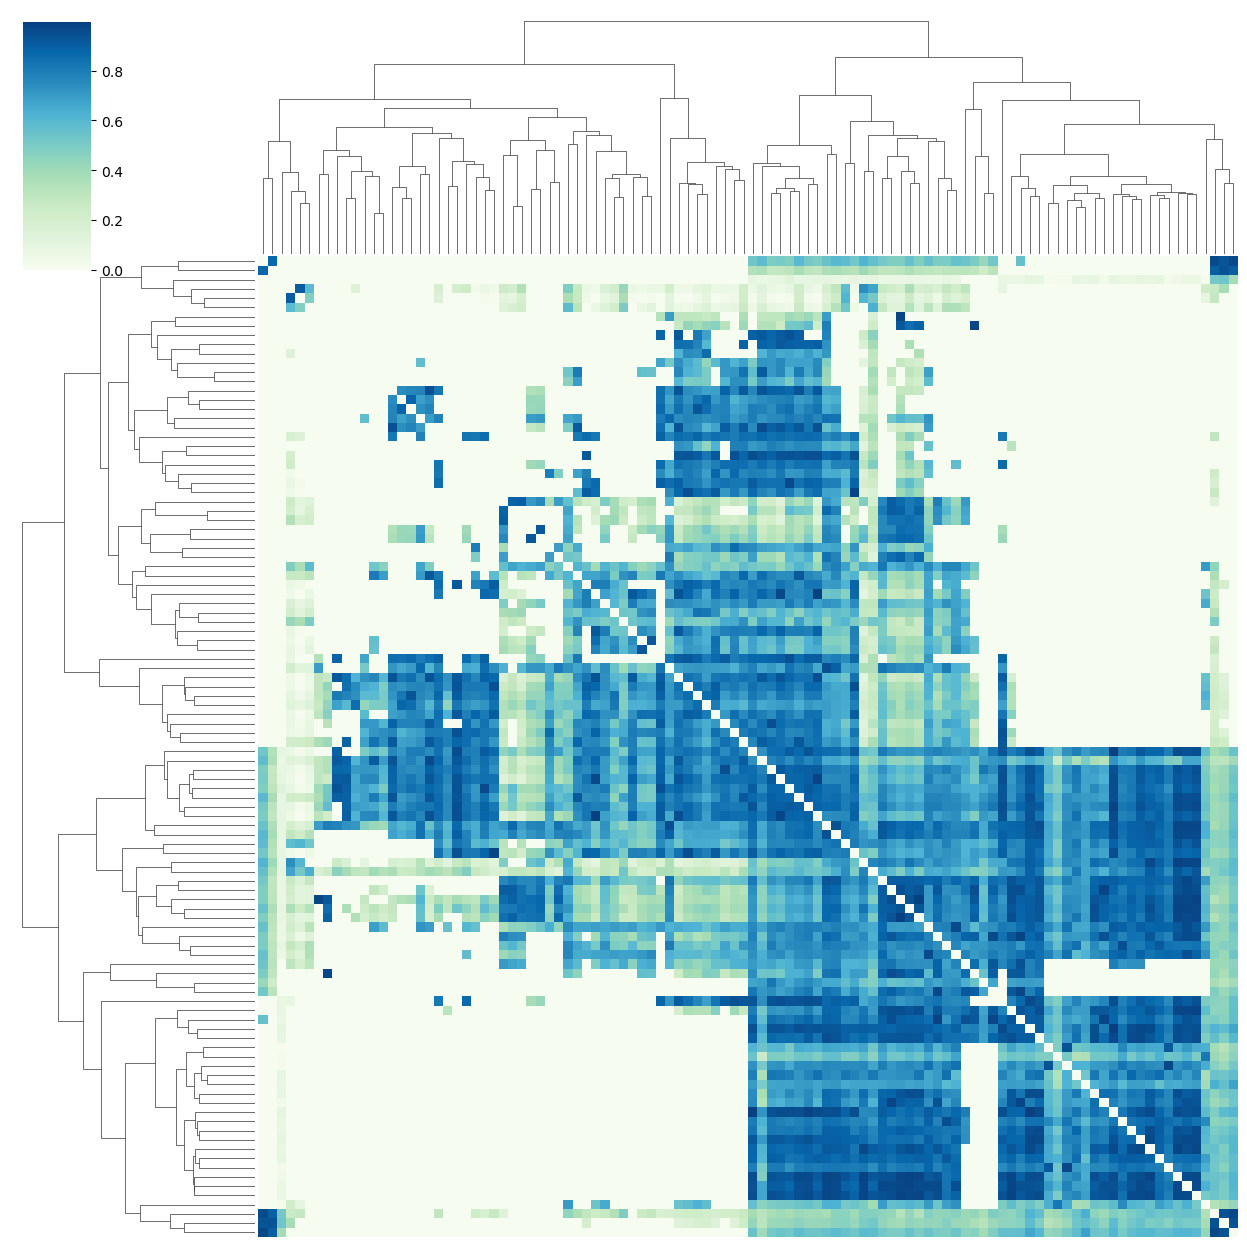

In [21]:
mean_d = {}
min_datasets = 5

counter = 0
for ii, x in ii_dict.items():
    if len(x) >= min_datasets:
        if not all(np.array(x)==0):
            mean_d[ii] = np.mean(x)
            
selected_ions = list(set([item for tuple in mean_d for item in tuple]))

df = pd.DataFrame(np.zeros(len(selected_ions)*len(selected_ions)).reshape((len(selected_ions), -1)), columns=selected_ions, index=selected_ions)

for k, v in mean_d.items():
    df.loc[k[0], k[1]] = v
    df.loc[k[1], k[0]] = v

cm = 1/2.54
a = sns.clustermap(df, figsize=(35*cm, 35*cm), cmap='GnBu')
a.ax_heatmap.set_xticks([])
a.ax_heatmap.set_yticks([])

plt.savefig("plots/coloc_heatmap.png", dpi=400)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Network neighbors vs. Not neighbors: Mann-Whitney-Wilcoxon test two-sided, P_val:1.438e-17 U_stat=2.368e+07


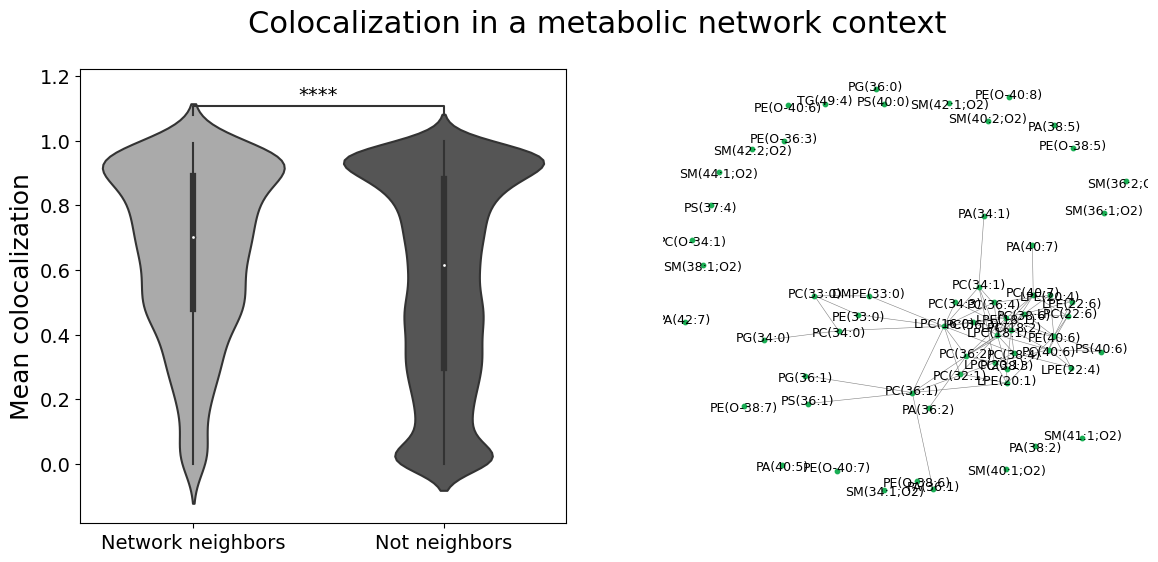

In [106]:
def catch_sp(g, source, target):
    try:
        return nx.shortest_path_length(g, source, target)
    except:
        return np.inf
    
edge_cor = []
nedge_cor = []
eds_l = []
nds_l = []

for dsid in lx_nets.keys():
    
    ls = coloc_dict[dsid]
    #led = list(ig.edges)
    ig = lx_nets[dsid]

    max_hops = 1
    node_list = list(lx_nets[dsid].nodes)
    for l1 in range(len(node_list)):
        for l2 in range(l1+1, len(node_list)):
            if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                eds_l.append(dsid)
            else:
                nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                nds_l.append(dsid)

tmp_dat = pd.concat([
    pd.DataFrame({'cor': edge_cor, 'grouping': 'Network neighbors', 'dataset': eds_l}),
    pd.DataFrame({'cor': nedge_cor, 'grouping': 'Not neighbors', 'dataset': nds_l}),
          ])

cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(35*cm, 15*cm))

plt.suptitle('Colocalization in a metabolic network context')
            
sns.violinplot(data=tmp_dat, x='grouping', y='cor', ax=ax1, palette='binary')

annotator = Annotator(ax1, 
                      [('Network neighbors', 'Not neighbors')], 
                      data=tmp_dat, x='grouping', y='cor', 
                      order=['Network neighbors', 'Not neighbors'])
annotator.configure(test="Mann-Whitney")
annotator.apply_and_annotate()
ax1.set_ylabel('Mean colocalization')
ax1.set_xlabel('')

pos = nx.spring_layout(ion_net, k=.25)
nx.draw_networkx_nodes(ion_net, node_color='#1aae54', node_size=10, pos=pos, ax=ax2)
nx.draw_networkx_edges(ion_net, width=.4, pos=pos, ax=ax2, edge_color='grey')
nx.draw_networkx_labels(ion_net, pos=nudge(pos, 0, 0.01),
                            labels={k: v['sum_species'].index[0] for k, v in dict(ion_net.nodes(data=True)).items()},
                            font_size=9, ax=ax2)
ax2.axis('off')

plt.savefig("plots/networks.png", dpi=400)
 
plt.show()